# Лабораторная работа №4: Optuna

## Постановка задачи

1. Найти оптимумы тестовых функций средствами Optuna

2. Осуществить подбор параметров модели классификации с помощью Optuna

3. Визуализировать полученный результат

## Источники

* [Документация по Optuna](https://optuna.readthedocs.io/en/stable/index.html)
* [Логистическая регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


# Подключение зависимостей

In [45]:
import logging
import sys
import math
import plotly
import optuna
import numpy as np
import sklearn

from matplotlib import pyplot as plt

# Вспомогательные функции

In [3]:
def draw_search_result(prob, found_params: np.ndarray, resolution: int = 1000):

  """ Визузуализация проблемы

  Args:
      prob (_type_): Проблема
      resolution (int, optional): Разрешение сетки. Defaults to 1000.
  """

  bounds = np.array(prob.get_bounds())
  fitness = prob.fitness
  glob_min = prob.get_glob_min()

  x = np.linspace(bounds[0, 0], bounds[1, 0], resolution)
  y = np.linspace(bounds[0, 1], bounds[1, 1], resolution)

  x_grid, y_grid = np.meshgrid(x, y)
  z_grid = fitness([x_grid, y_grid])

  fig = plt.figure(figsize = (10, 8))
  ax = plt.axes()

  ax.set_title(prob.__name__)
  ax.legend(loc="upper left")
  ax.set_xlabel('x')
  ax.set_ylabel('y')

  plt.contour(x_grid, y_grid, z_grid, 20);
  ax.contour(x_grid, y_grid, z_grid, 20);
  ax.scatter(glob_min[0], glob_min[1], s=100, c="red", lw=2, ec='black', marker = 'o', label="Глобальный минимум")
  ax.scatter(found_params[0], found_params[1], s=150, c="white", lw=2, ec='black', marker = 'X', label="Найденный минимум")
  plt.colorbar()
  ax.legend()

  x_error = abs(found_params[0] - prob.get_glob_min()[0]) 
  y_error = abs(found_params[1] - prob.get_glob_min()[1]) 
  z_error = abs(prob.fitness(found_params) - prob.get_glob_min()[2]) 
  print(f'Погрешность: {x_error, y_error, z_error}')

# 1. Поиск оптимума функции средствами Optuna

## Определение тестовых функций

### Функция Сферы
* Функция: $f(\boldsymbol{x}) = \sum_{i=1}^{n} x_{i}^{2}$
* Область определения: $ -\infty \le x_{i} \le \infty$
* Глобальный минимум: $f(x_{1}, \dots, x_{n}) = f(0, \dots, 0) = 0$

In [4]:
class Sphere:

    @staticmethod
    def fitness(x: np.ndarray):
        return x[0]*x[0] + x[1]*x[1]

    @staticmethod
    def get_bounds():
        return np.array([[-10., -10.], [10., 10.]])

    @staticmethod
    def get_glob_min():
        return np.array([0., 0., 0.])
    
    @staticmethod
    def get_default_start_point():
        return np.array([2.0, 2.7])

### Функция Мак Кормика
* Функция: $f(x,y) = \sin \left(x+y\right) + \left(x-y\right)^{2} - 1.5x + 2.5y + 1$
* Область определения: $-1.5\le x \le 4 \:and\: -3\le y \le 4$
* Глобальный минимум: $f(-0.54719,-1.54719) = -1.9133$

In [5]:
class McCormick:

    @staticmethod
    def fitness(x: np.ndarray):
        return np.sin(x[0] + x[1]) + (x[0] - x[1]) ** 2 - 1.5 * x[0] + 2.5 * x[1] + 1

    @staticmethod
    def get_bounds():
        return np.array([[-1.5, -3.], [5., 4.]])

    @staticmethod
    def get_glob_min():
        return np.array([-0.54719, -1.54719, -1.9133])

    @staticmethod
    def get_default_start_point():
        return np.array([-1.0, 3.0])

## Поиск оптимумов функции сферы

In [6]:
def objective_Sphere(trial):
  x = np.array([0, 0])
  x[0] = trial.suggest_float("x[0]", Sphere.get_bounds()[0,0], Sphere.get_bounds()[1,0])
  x[1] = trial.suggest_float("x[1]", Sphere.get_bounds()[0,1], Sphere.get_bounds()[1,1])
  return Sphere.fitness(x)

study = optuna.create_study()
study.optimize(objective_Sphere, n_trials = 200)
found_params = [study.best_params["x[0]"], study.best_params["x[1]"]]

[I 2022-12-25 14:57:12,754] A new study created in memory with name: no-name-508c64e3-711f-4b9e-bdca-c00b223b941c
[I 2022-12-25 14:57:12,758] Trial 0 finished with value: 98.0 and parameters: {'x[0]': -7.945257627036463, 'x[1]': 7.939905301308734}. Best is trial 0 with value: 98.0.
[I 2022-12-25 14:57:12,761] Trial 1 finished with value: 17.0 and parameters: {'x[0]': 1.4393247364186674, 'x[1]': 4.445689483718336}. Best is trial 1 with value: 17.0.
[I 2022-12-25 14:57:12,763] Trial 2 finished with value: 1.0 and parameters: {'x[0]': -1.7088477789450511, 'x[1]': 0.5056611563841393}. Best is trial 2 with value: 1.0.
[I 2022-12-25 14:57:12,765] Trial 3 finished with value: 82.0 and parameters: {'x[0]': -1.747618063115688, 'x[1]': 9.743630423673732}. Best is trial 2 with value: 1.0.
[I 2022-12-25 14:57:12,766] Trial 4 finished with value: 40.0 and parameters: {'x[0]': 6.853952948500183, 'x[1]': -2.271227026439706}. Best is trial 2 with value: 1.0.
[I 2022-12-25 14:57:12,769] Trial 5 finishe

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Погрешность: (0.27996878962420946, 0.5450316524313435, 0.3754420253156857)


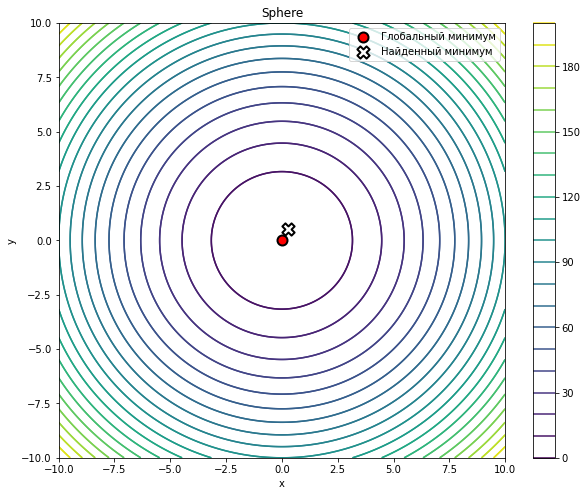

In [7]:
draw_search_result(Sphere, found_params)

## Поиск оптимумов функции Мак Кормика

In [8]:
def objective_McCormick(trial):
  x = np.array([0, 0])
  x[0] = trial.suggest_float("x[0]", McCormick.get_bounds()[0,0], McCormick.get_bounds()[1,0])
  x[1] = trial.suggest_float("x[1]", McCormick.get_bounds()[0,1], McCormick.get_bounds()[1,1])
  return McCormick.fitness(x)

study = optuna.create_study()
study.optimize(objective_McCormick, n_trials = 200)
found_params = [study.best_params["x[0]"], study.best_params["x[1]"]]

[I 2022-12-25 14:57:16,139] A new study created in memory with name: no-name-01e3f47e-8bfe-4dd2-8998-1557fc7e12c2
[I 2022-12-25 14:57:16,143] Trial 0 finished with value: 5.541075725336862 and parameters: {'x[0]': 2.9539437966458895, 'x[1]': 3.718004939395131}. Best is trial 0 with value: 5.541075725336862.
[I 2022-12-25 14:57:16,145] Trial 1 finished with value: 1.6411200080598671 and parameters: {'x[0]': 2.898768689478154, 'x[1]': 1.4510527809176441}. Best is trial 1 with value: 1.6411200080598671.
[I 2022-12-25 14:57:16,147] Trial 2 finished with value: 5.641120008059867 and parameters: {'x[0]': 1.7643111574736299, 'x[1]': 2.301176993521766}. Best is trial 1 with value: 1.6411200080598671.
[I 2022-12-25 14:57:16,148] Trial 3 finished with value: 4.156986598718789 and parameters: {'x[0]': 4.916501909146745, 'x[1]': 3.0843626403674955}. Best is trial 1 with value: 1.6411200080598671.
[I 2022-12-25 14:57:16,150] Trial 4 finished with value: -0.9092974268256819 and parameters: {'x[0]': 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Погрешность: (0.6294436615725179, 0.09975108314348713, 0.5323451923603115)


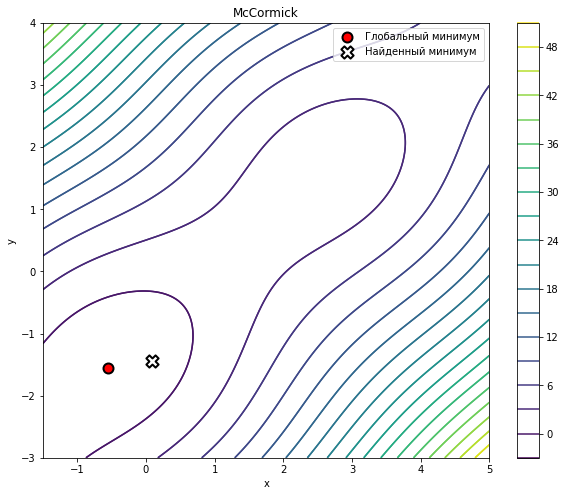

In [9]:
draw_search_result(McCormick, found_params)

# 2. Подбор параметров для логистической регрессии

Решение задачи классификации ирисов c помощью подбора параметров логистической регрессии средствами Optuna

## Загрузка датасета

In [ ]:
X, y = sklearn.datasets.load_iris(return_X_y=True)
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(X, y)

## Определение оптимизируемой функции

In [97]:
def objective(trial):
  C = trial.suggest_float("C", 1e-5, 1, log=True)
  tol = trial.suggest_float("tol", 1e-1, 10, log=True)
  solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
  clf = sklearn.linear_model.LogisticRegression(C=C, tol=tol, solver=solver)
  
  for step in range(100):
    clf.fit(train_x, train_y)
    intermediate_value = clf.score(valid_x, valid_y)
    trial.report(intermediate_value, step=step)
    
    if trial.should_prune():
      raise optuna.TrialPruned()
      
    return clf.score(valid_x, valid_y)



[I 2022-12-25 15:14:35,623] A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f


A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac09c-b177-4d70-8df1-f8907cb9108f
A new study created in memory with name: no-name-96bac

[I 2022-12-25 15:14:35,653] Trial 0 finished with value: 0.868421052631579 and parameters: {'C': 0.42164264447473004, 'tol': 0.8404576062521228, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.868421052631579.


Trial 0 finished with value: 0.868421052631579 and parameters: {'C': 0.42164264447473004, 'tol': 0.8404576062521228, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.868421052631579.
Trial 0 finished with value: 0.868421052631579 and parameters: {'C': 0.42164264447473004, 'tol': 0.8404576062521228, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.868421052631579.
Trial 0 finished with value: 0.868421052631579 and parameters: {'C': 0.42164264447473004, 'tol': 0.8404576062521228, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.868421052631579.
Trial 0 finished with value: 0.868421052631579 and parameters: {'C': 0.42164264447473004, 'tol': 0.8404576062521228, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.868421052631579.
Trial 0 finished with value: 0.868421052631579 and parameters: {'C': 0.42164264447473004, 'tol': 0.8404576062521228, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.868421052631579.
Trial 0 finished with value: 0.868421052631579 and parameter

[I 2022-12-25 15:14:35,670] Trial 1 finished with value: 0.3684210526315789 and parameters: {'C': 7.881860002042305e-05, 'tol': 3.5903394914570574, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.


Trial 1 finished with value: 0.3684210526315789 and parameters: {'C': 7.881860002042305e-05, 'tol': 3.5903394914570574, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 1 finished with value: 0.3684210526315789 and parameters: {'C': 7.881860002042305e-05, 'tol': 3.5903394914570574, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 1 finished with value: 0.3684210526315789 and parameters: {'C': 7.881860002042305e-05, 'tol': 3.5903394914570574, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 1 finished with value: 0.3684210526315789 and parameters: {'C': 7.881860002042305e-05, 'tol': 3.5903394914570574, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 1 finished with value: 0.3684210526315789 and parameters: {'C': 7.881860002042305e-05, 'tol': 3.5903394914570574, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 1 finished with value: 0.3684210526315789 and parameters: {'C': 

[I 2022-12-25 15:14:35,689] Trial 2 finished with value: 0.3684210526315789 and parameters: {'C': 5.606497404350296e-05, 'tol': 3.387492501713514, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.


Trial 2 finished with value: 0.3684210526315789 and parameters: {'C': 5.606497404350296e-05, 'tol': 3.387492501713514, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 2 finished with value: 0.3684210526315789 and parameters: {'C': 5.606497404350296e-05, 'tol': 3.387492501713514, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 2 finished with value: 0.3684210526315789 and parameters: {'C': 5.606497404350296e-05, 'tol': 3.387492501713514, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 2 finished with value: 0.3684210526315789 and parameters: {'C': 5.606497404350296e-05, 'tol': 3.387492501713514, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 2 finished with value: 0.3684210526315789 and parameters: {'C': 5.606497404350296e-05, 'tol': 3.387492501713514, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 2 finished with value: 0.36842105263157

[I 2022-12-25 15:14:35,706] Trial 3 finished with value: 0.6578947368421053 and parameters: {'C': 0.029602557378157687, 'tol': 1.6337720277704089, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.


Trial 3 finished with value: 0.6578947368421053 and parameters: {'C': 0.029602557378157687, 'tol': 1.6337720277704089, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 3 finished with value: 0.6578947368421053 and parameters: {'C': 0.029602557378157687, 'tol': 1.6337720277704089, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 3 finished with value: 0.6578947368421053 and parameters: {'C': 0.029602557378157687, 'tol': 1.6337720277704089, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 3 finished with value: 0.6578947368421053 and parameters: {'C': 0.029602557378157687, 'tol': 1.6337720277704089, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 3 finished with value: 0.6578947368421053 and parameters: {'C': 0.029602557378157687, 'tol': 1.6337720277704089, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 3 finished with value: 0.65789473684210

[I 2022-12-25 15:14:35,728] Trial 4 finished with value: 0.6578947368421053 and parameters: {'C': 0.00020536648664929455, 'tol': 2.4152148997396696, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.


Trial 4 finished with value: 0.6578947368421053 and parameters: {'C': 0.00020536648664929455, 'tol': 2.4152148997396696, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 4 finished with value: 0.6578947368421053 and parameters: {'C': 0.00020536648664929455, 'tol': 2.4152148997396696, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 4 finished with value: 0.6578947368421053 and parameters: {'C': 0.00020536648664929455, 'tol': 2.4152148997396696, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 4 finished with value: 0.6578947368421053 and parameters: {'C': 0.00020536648664929455, 'tol': 2.4152148997396696, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 4 finished with value: 0.6578947368421053 and parameters: {'C': 0.00020536648664929455, 'tol': 2.4152148997396696, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 4 finished with value: 0.6578

[I 2022-12-25 15:14:35,751] Trial 5 finished with value: 0.6578947368421053 and parameters: {'C': 0.0004573337439509409, 'tol': 0.2852117344640915, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.


Trial 5 finished with value: 0.6578947368421053 and parameters: {'C': 0.0004573337439509409, 'tol': 0.2852117344640915, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 5 finished with value: 0.6578947368421053 and parameters: {'C': 0.0004573337439509409, 'tol': 0.2852117344640915, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 5 finished with value: 0.6578947368421053 and parameters: {'C': 0.0004573337439509409, 'tol': 0.2852117344640915, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 5 finished with value: 0.6578947368421053 and parameters: {'C': 0.0004573337439509409, 'tol': 0.2852117344640915, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 5 finished with value: 0.6578947368421053 and parameters: {'C': 0.0004573337439509409, 'tol': 0.2852117344640915, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 5 finished with value: 0.6578947368421053 and paramete

[I 2022-12-25 15:14:35,767] Trial 6 finished with value: 0.6578947368421053 and parameters: {'C': 0.006834591659070935, 'tol': 0.2528661352617479, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.


Trial 6 finished with value: 0.6578947368421053 and parameters: {'C': 0.006834591659070935, 'tol': 0.2528661352617479, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 6 finished with value: 0.6578947368421053 and parameters: {'C': 0.006834591659070935, 'tol': 0.2528661352617479, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 6 finished with value: 0.6578947368421053 and parameters: {'C': 0.006834591659070935, 'tol': 0.2528661352617479, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 6 finished with value: 0.6578947368421053 and parameters: {'C': 0.006834591659070935, 'tol': 0.2528661352617479, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 6 finished with value: 0.6578947368421053 and parameters: {'C': 0.006834591659070935, 'tol': 0.2528661352617479, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 6 finished with value: 0.6578947368421053 and parameters: {'C': 0.006

[I 2022-12-25 15:14:35,786] Trial 7 finished with value: 0.7631578947368421 and parameters: {'C': 0.02470871077284938, 'tol': 5.761309204519663, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.


Trial 7 finished with value: 0.7631578947368421 and parameters: {'C': 0.02470871077284938, 'tol': 5.761309204519663, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 7 finished with value: 0.7631578947368421 and parameters: {'C': 0.02470871077284938, 'tol': 5.761309204519663, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 7 finished with value: 0.7631578947368421 and parameters: {'C': 0.02470871077284938, 'tol': 5.761309204519663, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 7 finished with value: 0.7631578947368421 and parameters: {'C': 0.02470871077284938, 'tol': 5.761309204519663, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 7 finished with value: 0.7631578947368421 and parameters: {'C': 0.02470871077284938, 'tol': 5.761309204519663, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.3684210526315789.
Trial 7 finished with value: 0.7631578947368421 and par

[I 2022-12-25 15:14:35,808] Trial 8 finished with value: 0.8947368421052632 and parameters: {'C': 0.01100678857401575, 'tol': 3.4924303783381268, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.


Trial 8 finished with value: 0.8947368421052632 and parameters: {'C': 0.01100678857401575, 'tol': 3.4924303783381268, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 8 finished with value: 0.8947368421052632 and parameters: {'C': 0.01100678857401575, 'tol': 3.4924303783381268, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 8 finished with value: 0.8947368421052632 and parameters: {'C': 0.01100678857401575, 'tol': 3.4924303783381268, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 8 finished with value: 0.8947368421052632 and parameters: {'C': 0.01100678857401575, 'tol': 3.4924303783381268, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 8 finished with value: 0.8947368421052632 and parameters: {'C': 0.01100678857401575, 'tol': 3.4924303783381268, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.3684210526315789.
Trial 8 finished with value: 0.8947368421052632 and parameters: {'C': 

[I 2022-12-25 15:14:35,825] Trial 9 finished with value: 0.6578947368421053 and parameters: {'C': 0.0007340661582659555, 'tol': 3.850724394852371, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.


Trial 9 finished with value: 0.6578947368421053 and parameters: {'C': 0.0007340661582659555, 'tol': 3.850724394852371, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 9 finished with value: 0.6578947368421053 and parameters: {'C': 0.0007340661582659555, 'tol': 3.850724394852371, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 9 finished with value: 0.6578947368421053 and parameters: {'C': 0.0007340661582659555, 'tol': 3.850724394852371, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 9 finished with value: 0.6578947368421053 and parameters: {'C': 0.0007340661582659555, 'tol': 3.850724394852371, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 9 finished with value: 0.6578947368421053 and parameters: {'C': 0.0007340661582659555, 'tol': 3.850724394852371, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 9 finished with value: 0.6578947368421053 and parameters: {'C': 0.000

[I 2022-12-25 15:14:35,850] Trial 10 finished with value: 0.6578947368421053 and parameters: {'C': 2.118618774549218e-05, 'tol': 0.7209105193906844, 'solver': 'saga'}. Best is trial 1 with value: 0.3684210526315789.


Trial 10 finished with value: 0.6578947368421053 and parameters: {'C': 2.118618774549218e-05, 'tol': 0.7209105193906844, 'solver': 'saga'}. Best is trial 1 with value: 0.3684210526315789.
Trial 10 finished with value: 0.6578947368421053 and parameters: {'C': 2.118618774549218e-05, 'tol': 0.7209105193906844, 'solver': 'saga'}. Best is trial 1 with value: 0.3684210526315789.
Trial 10 finished with value: 0.6578947368421053 and parameters: {'C': 2.118618774549218e-05, 'tol': 0.7209105193906844, 'solver': 'saga'}. Best is trial 1 with value: 0.3684210526315789.
Trial 10 finished with value: 0.6578947368421053 and parameters: {'C': 2.118618774549218e-05, 'tol': 0.7209105193906844, 'solver': 'saga'}. Best is trial 1 with value: 0.3684210526315789.
Trial 10 finished with value: 0.6578947368421053 and parameters: {'C': 2.118618774549218e-05, 'tol': 0.7209105193906844, 'solver': 'saga'}. Best is trial 1 with value: 0.3684210526315789.
Trial 10 finished with value: 0.6578947368421053 and paramet

[I 2022-12-25 15:14:35,876] Trial 11 finished with value: 0.3684210526315789 and parameters: {'C': 1.2625880049007963e-05, 'tol': 9.515557910238638, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.


Trial 11 finished with value: 0.3684210526315789 and parameters: {'C': 1.2625880049007963e-05, 'tol': 9.515557910238638, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 11 finished with value: 0.3684210526315789 and parameters: {'C': 1.2625880049007963e-05, 'tol': 9.515557910238638, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 11 finished with value: 0.3684210526315789 and parameters: {'C': 1.2625880049007963e-05, 'tol': 9.515557910238638, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 11 finished with value: 0.3684210526315789 and parameters: {'C': 1.2625880049007963e-05, 'tol': 9.515557910238638, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 11 finished with value: 0.3684210526315789 and parameters: {'C': 1.2625880049007963e-05, 'tol': 9.515557910238638, 'solver': 'sag'}. Best is trial 1 with value: 0.3684210526315789.
Trial 11 finished with value: 0.3684210526315789 and parameters: 

[I 2022-12-25 15:14:35,899] Trial 12 finished with value: 0.3684210526315789 and parameters: {'C': 0.00010830262830768971, 'tol': 1.5022025522255253, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.


Trial 12 finished with value: 0.3684210526315789 and parameters: {'C': 0.00010830262830768971, 'tol': 1.5022025522255253, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 12 finished with value: 0.3684210526315789 and parameters: {'C': 0.00010830262830768971, 'tol': 1.5022025522255253, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 12 finished with value: 0.3684210526315789 and parameters: {'C': 0.00010830262830768971, 'tol': 1.5022025522255253, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 12 finished with value: 0.3684210526315789 and parameters: {'C': 0.00010830262830768971, 'tol': 1.5022025522255253, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 12 finished with value: 0.3684210526315789 and parameters: {'C': 0.00010830262830768971, 'tol': 1.5022025522255253, 'solver': 'liblinear'}. Best is trial 1 with value: 0.3684210526315789.
Trial 12 finished with value: 

[I 2022-12-25 15:14:35,924] Trial 13 finished with value: 0.2894736842105263 and parameters: {'C': 4.186926359998849e-05, 'tol': 9.700950388074748, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 13 finished with value: 0.2894736842105263 and parameters: {'C': 4.186926359998849e-05, 'tol': 9.700950388074748, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 13 finished with value: 0.2894736842105263 and parameters: {'C': 4.186926359998849e-05, 'tol': 9.700950388074748, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 13 finished with value: 0.2894736842105263 and parameters: {'C': 4.186926359998849e-05, 'tol': 9.700950388074748, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 13 finished with value: 0.2894736842105263 and parameters: {'C': 4.186926359998849e-05, 'tol': 9.700950388074748, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 13 finished with value: 0.2894736842105263 and parameters: {'C': 4.186926359998849e-05, 'tol': 9.700950388074748, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 13 finished with value: 0.2894736842105263 and paramet

[I 2022-12-25 15:14:35,948] Trial 14 finished with value: 0.39473684210526316 and parameters: {'C': 0.0013551839600097846, 'tol': 8.938363969419058, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 14 finished with value: 0.39473684210526316 and parameters: {'C': 0.0013551839600097846, 'tol': 8.938363969419058, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 14 finished with value: 0.39473684210526316 and parameters: {'C': 0.0013551839600097846, 'tol': 8.938363969419058, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 14 finished with value: 0.39473684210526316 and parameters: {'C': 0.0013551839600097846, 'tol': 8.938363969419058, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 14 finished with value: 0.39473684210526316 and parameters: {'C': 0.0013551839600097846, 'tol': 8.938363969419058, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 14 finished with value: 0.39473684210526316 and parameters: {'C': 0.0013551839600097846, 'tol': 8.938363969419058, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 14 finished with value: 0.39473684210526316 and p

[I 2022-12-25 15:14:35,979] Trial 15 finished with value: 0.6578947368421053 and parameters: {'C': 4.1600326393295734e-05, 'tol': 0.11295804845712888, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 15 finished with value: 0.6578947368421053 and parameters: {'C': 4.1600326393295734e-05, 'tol': 0.11295804845712888, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 15 finished with value: 0.6578947368421053 and parameters: {'C': 4.1600326393295734e-05, 'tol': 0.11295804845712888, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 15 finished with value: 0.6578947368421053 and parameters: {'C': 4.1600326393295734e-05, 'tol': 0.11295804845712888, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 15 finished with value: 0.6578947368421053 and parameters: {'C': 4.1600326393295734e-05, 'tol': 0.11295804845712888, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 15 finished with value: 0.6578947368421053 and parameters: {'C': 4.1600326393295734e-05, 'tol': 0.11295804845712888, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 15 finished with value: 0.6578947368421

[I 2022-12-25 15:14:36,003] Trial 16 finished with value: 0.34210526315789475 and parameters: {'C': 0.00019253140666690956, 'tol': 5.867980742722924, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 16 finished with value: 0.34210526315789475 and parameters: {'C': 0.00019253140666690956, 'tol': 5.867980742722924, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 16 finished with value: 0.34210526315789475 and parameters: {'C': 0.00019253140666690956, 'tol': 5.867980742722924, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 16 finished with value: 0.34210526315789475 and parameters: {'C': 0.00019253140666690956, 'tol': 5.867980742722924, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 16 finished with value: 0.34210526315789475 and parameters: {'C': 0.00019253140666690956, 'tol': 5.867980742722924, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 16 finished with value: 0.34210526315789475 and parameters: {'C': 0.00019253140666690956, 'tol': 5.867980742722924, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 16 finished with value: 0.34210526315789475 

[I 2022-12-25 15:14:36,028] Trial 17 finished with value: 0.631578947368421 and parameters: {'C': 0.0018233040732181217, 'tol': 7.6495934808029, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 17 finished with value: 0.631578947368421 and parameters: {'C': 0.0018233040732181217, 'tol': 7.6495934808029, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 17 finished with value: 0.631578947368421 and parameters: {'C': 0.0018233040732181217, 'tol': 7.6495934808029, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 17 finished with value: 0.631578947368421 and parameters: {'C': 0.0018233040732181217, 'tol': 7.6495934808029, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 17 finished with value: 0.631578947368421 and parameters: {'C': 0.0018233040732181217, 'tol': 7.6495934808029, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 17 finished with value: 0.631578947368421 and parameters: {'C': 0.0018233040732181217, 'tol': 7.6495934808029, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 17 finished with value: 0.631578947368421 and parameters: {'C': 0.001

[I 2022-12-25 15:14:36,053] Trial 18 finished with value: 0.34210526315789475 and parameters: {'C': 0.0002336027466778359, 'tol': 6.06157500291967, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 18 finished with value: 0.34210526315789475 and parameters: {'C': 0.0002336027466778359, 'tol': 6.06157500291967, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 18 finished with value: 0.34210526315789475 and parameters: {'C': 0.0002336027466778359, 'tol': 6.06157500291967, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 18 finished with value: 0.34210526315789475 and parameters: {'C': 0.0002336027466778359, 'tol': 6.06157500291967, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 18 finished with value: 0.34210526315789475 and parameters: {'C': 0.0002336027466778359, 'tol': 6.06157500291967, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 18 finished with value: 0.34210526315789475 and parameters: {'C': 0.0002336027466778359, 'tol': 6.06157500291967, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 18 finished with value: 0.34210526315789475 and parame

[I 2022-12-25 15:14:36,075] Trial 19 finished with value: 0.631578947368421 and parameters: {'C': 1.0907164090340842e-05, 'tol': 0.49410217448750365, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 19 finished with value: 0.631578947368421 and parameters: {'C': 1.0907164090340842e-05, 'tol': 0.49410217448750365, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 19 finished with value: 0.631578947368421 and parameters: {'C': 1.0907164090340842e-05, 'tol': 0.49410217448750365, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 19 finished with value: 0.631578947368421 and parameters: {'C': 1.0907164090340842e-05, 'tol': 0.49410217448750365, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 19 finished with value: 0.631578947368421 and parameters: {'C': 1.0907164090340842e-05, 'tol': 0.49410217448750365, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 19 finished with value: 0.631578947368421 and parameters: {'C': 1.0907164090340842e-05, 'tol': 0.49410217448750365, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 19 finished with value: 0.631578947368421 an

[I 2022-12-25 15:14:36,098] Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 0.7137590522949073, 'tol': 1.7119277497383703, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 0.7137590522949073, 'tol': 1.7119277497383703, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 0.7137590522949073, 'tol': 1.7119277497383703, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 0.7137590522949073, 'tol': 1.7119277497383703, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 0.7137590522949073, 'tol': 1.7119277497383703, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 0.7137590522949073, 'tol': 1.7119277497383703, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 0.713

[I 2022-12-25 15:14:36,120] Trial 21 finished with value: 0.631578947368421 and parameters: {'C': 0.0002609764113526217, 'tol': 5.881694408155209, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 21 finished with value: 0.631578947368421 and parameters: {'C': 0.0002609764113526217, 'tol': 5.881694408155209, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 21 finished with value: 0.631578947368421 and parameters: {'C': 0.0002609764113526217, 'tol': 5.881694408155209, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 21 finished with value: 0.631578947368421 and parameters: {'C': 0.0002609764113526217, 'tol': 5.881694408155209, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 21 finished with value: 0.631578947368421 and parameters: {'C': 0.0002609764113526217, 'tol': 5.881694408155209, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 21 finished with value: 0.631578947368421 and parameters: {'C': 0.0002609764113526217, 'tol': 5.881694408155209, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 21 finished with value: 0.631578947368421 and parameters: {

[I 2022-12-25 15:14:36,144] Trial 22 finished with value: 0.6578947368421053 and parameters: {'C': 0.00016981426941655052, 'tol': 5.4572017394336685, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 22 finished with value: 0.6578947368421053 and parameters: {'C': 0.00016981426941655052, 'tol': 5.4572017394336685, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 22 finished with value: 0.6578947368421053 and parameters: {'C': 0.00016981426941655052, 'tol': 5.4572017394336685, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 22 finished with value: 0.6578947368421053 and parameters: {'C': 0.00016981426941655052, 'tol': 5.4572017394336685, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 22 finished with value: 0.6578947368421053 and parameters: {'C': 0.00016981426941655052, 'tol': 5.4572017394336685, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 22 finished with value: 0.6578947368421053 and parameters: {'C': 0.00016981426941655052, 'tol': 5.4572017394336685, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 22 finished with value: 0.6578947368421053 a

[I 2022-12-25 15:14:36,170] Trial 23 finished with value: 0.34210526315789475 and parameters: {'C': 3.5563339523954556e-05, 'tol': 9.889324607625639, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 23 finished with value: 0.34210526315789475 and parameters: {'C': 3.5563339523954556e-05, 'tol': 9.889324607625639, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 23 finished with value: 0.34210526315789475 and parameters: {'C': 3.5563339523954556e-05, 'tol': 9.889324607625639, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 23 finished with value: 0.34210526315789475 and parameters: {'C': 3.5563339523954556e-05, 'tol': 9.889324607625639, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 23 finished with value: 0.34210526315789475 and parameters: {'C': 3.5563339523954556e-05, 'tol': 9.889324607625639, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 23 finished with value: 0.34210526315789475 and parameters: {'C': 3.5563339523954556e-05, 'tol': 9.889324607625639, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 23 finished with value: 0.34210526315789475 

[I 2022-12-25 15:14:36,195] Trial 24 finished with value: 0.34210526315789475 and parameters: {'C': 2.6294175993989038e-05, 'tol': 9.397528999127834, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.


Trial 24 finished with value: 0.34210526315789475 and parameters: {'C': 2.6294175993989038e-05, 'tol': 9.397528999127834, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 24 finished with value: 0.34210526315789475 and parameters: {'C': 2.6294175993989038e-05, 'tol': 9.397528999127834, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 24 finished with value: 0.34210526315789475 and parameters: {'C': 2.6294175993989038e-05, 'tol': 9.397528999127834, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 24 finished with value: 0.34210526315789475 and parameters: {'C': 2.6294175993989038e-05, 'tol': 9.397528999127834, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 24 finished with value: 0.34210526315789475 and parameters: {'C': 2.6294175993989038e-05, 'tol': 9.397528999127834, 'solver': 'saga'}. Best is trial 13 with value: 0.2894736842105263.
Trial 24 finished with value: 0.34210526315789475 

[I 2022-12-25 15:14:36,221] Trial 25 finished with value: 0.3684210526315789 and parameters: {'C': 3.798575330811587e-05, 'tol': 2.3011764497540343, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.2894736842105263.


Trial 25 finished with value: 0.3684210526315789 and parameters: {'C': 3.798575330811587e-05, 'tol': 2.3011764497540343, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.2894736842105263.
Trial 25 finished with value: 0.3684210526315789 and parameters: {'C': 3.798575330811587e-05, 'tol': 2.3011764497540343, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.2894736842105263.
Trial 25 finished with value: 0.3684210526315789 and parameters: {'C': 3.798575330811587e-05, 'tol': 2.3011764497540343, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.2894736842105263.
Trial 25 finished with value: 0.3684210526315789 and parameters: {'C': 3.798575330811587e-05, 'tol': 2.3011764497540343, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.2894736842105263.
Trial 25 finished with value: 0.3684210526315789 and parameters: {'C': 3.798575330811587e-05, 'tol': 2.3011764497540343, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.2894736842105263.
Trial 25 finished with value: 0.3684210526315789 a

[I 2022-12-25 15:14:36,245] Trial 26 finished with value: 0.2894736842105263 and parameters: {'C': 7.486968310511656e-05, 'tol': 4.688922479317888, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.


Trial 26 finished with value: 0.2894736842105263 and parameters: {'C': 7.486968310511656e-05, 'tol': 4.688922479317888, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 26 finished with value: 0.2894736842105263 and parameters: {'C': 7.486968310511656e-05, 'tol': 4.688922479317888, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 26 finished with value: 0.2894736842105263 and parameters: {'C': 7.486968310511656e-05, 'tol': 4.688922479317888, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 26 finished with value: 0.2894736842105263 and parameters: {'C': 7.486968310511656e-05, 'tol': 4.688922479317888, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 26 finished with value: 0.2894736842105263 and parameters: {'C': 7.486968310511656e-05, 'tol': 4.688922479317888, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 26 finished with value: 0.289

[I 2022-12-25 15:14:36,269] Trial 27 finished with value: 0.2894736842105263 and parameters: {'C': 1.94790913793744e-05, 'tol': 4.415104717891014, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.


Trial 27 finished with value: 0.2894736842105263 and parameters: {'C': 1.94790913793744e-05, 'tol': 4.415104717891014, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 27 finished with value: 0.2894736842105263 and parameters: {'C': 1.94790913793744e-05, 'tol': 4.415104717891014, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 27 finished with value: 0.2894736842105263 and parameters: {'C': 1.94790913793744e-05, 'tol': 4.415104717891014, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 27 finished with value: 0.2894736842105263 and parameters: {'C': 1.94790913793744e-05, 'tol': 4.415104717891014, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 27 finished with value: 0.2894736842105263 and parameters: {'C': 1.94790913793744e-05, 'tol': 4.415104717891014, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 27 finished with value: 0.28947368

[I 2022-12-25 15:14:36,294] Trial 28 finished with value: 0.2894736842105263 and parameters: {'C': 1.1159698341136799e-05, 'tol': 4.463631428495653, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.


Trial 28 finished with value: 0.2894736842105263 and parameters: {'C': 1.1159698341136799e-05, 'tol': 4.463631428495653, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 28 finished with value: 0.2894736842105263 and parameters: {'C': 1.1159698341136799e-05, 'tol': 4.463631428495653, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 28 finished with value: 0.2894736842105263 and parameters: {'C': 1.1159698341136799e-05, 'tol': 4.463631428495653, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 28 finished with value: 0.2894736842105263 and parameters: {'C': 1.1159698341136799e-05, 'tol': 4.463631428495653, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 28 finished with value: 0.2894736842105263 and parameters: {'C': 1.1159698341136799e-05, 'tol': 4.463631428495653, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 28 finished with value: 

[I 2022-12-25 15:14:36,319] Trial 29 finished with value: 0.3684210526315789 and parameters: {'C': 1.0834057649994289e-05, 'tol': 1.176727158176974, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.


Trial 29 finished with value: 0.3684210526315789 and parameters: {'C': 1.0834057649994289e-05, 'tol': 1.176727158176974, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 29 finished with value: 0.3684210526315789 and parameters: {'C': 1.0834057649994289e-05, 'tol': 1.176727158176974, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 29 finished with value: 0.3684210526315789 and parameters: {'C': 1.0834057649994289e-05, 'tol': 1.176727158176974, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 29 finished with value: 0.3684210526315789 and parameters: {'C': 1.0834057649994289e-05, 'tol': 1.176727158176974, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 29 finished with value: 0.3684210526315789 and parameters: {'C': 1.0834057649994289e-05, 'tol': 1.176727158176974, 'solver': 'liblinear'}. Best is trial 13 with value: 0.2894736842105263.
Trial 29 finished with value: 

## Оптимизация

In [ ]:

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=30)

## Результаты оптимизации

### История оптимизации
<img src="media/plot_optimization_history.png">

In [104]:
#optuna.visualization.plot_optimization_history(study)

### Взаимосвязи гиперпараметров
<img src="media/plot_parallel_coordinate.png">
<img src="media/plot_contour.png">

In [105]:
# optuna.visualization.plot_parallel_coordinate(study)

In [106]:
# optuna.visualization.plot_contour(study)

### Влияние признаков
<img src="media/plot_param_importances.png">

In [107]:
# optuna.visualization.plot_param_importances(study)

### Зависимость гиперпараметров от исходных значений
<img src="media/plot_slice.png">

In [108]:
# optuna.visualization.plot_slice(study)

### Эмпирическая функция распределения
<img src="media/plot_edf.png">

In [109]:
# optuna.visualization.plot_edf(study)